In [1]:
!pip install tensorflow_addons

# Train the model

In [2]:
import glob
import os
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Concatenate, Flatten, Dense

## Hyperparameters

In [3]:
EPOCHS = 1000
RESULT_SAVE_PATH = 'results/'

## Define the Inception-based model

In [4]:
def Model():
    def inception(filters):
        def subnetwork(x):
            h1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
            h1 = MaxPool2D()(h1)
            
            h2 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(h2)
            h2 = MaxPool2D()(h2)
            
            h3 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(h3)
            h3 = MaxPool2D()(h3)
            return Concatenate()([h1, h2, h3])
        return subnetwork
    
    x = tf.keras.Input(shape=(256, 256, 3))
    h = inception(16)(x)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = Flatten()(h)
    h = Dense(1024, activation='relu')(h)
    y = Dense(1, activation='sigmoid')(h)
    return tf.keras.Model(inputs=x, outputs=y)

## Define the preprocess (Data preprocessing)

In [5]:
def preprocess(img):
    return tf.image.convert_image_dtype(img, tf.float32)

## Define the Data Augmentation functions

In [6]:
def augmentation(img, label):
    def flip(x):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        return x
    
    def rotate(x):
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                   lambda: tfa.image.rotate(x,
                                       tf.random.uniform(shape=[], minval=0.0, maxval=360.0, dtype=tf.float32),
                                       interpolation='BILINEAR'),
                   lambda: x)
        return x
    
    def translation(x):
        dx = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        dy = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                    lambda: tfa.image.transform(x,
                                                [0, 0, dx, 0, 0, dy, 0, 0],
                                                interpolation='BILINEAR'),
                    lambda: x)
        return x
    
    img = flip(img)
    img = rotate(img)
    img = translation(img)
           
    return img, label

## Importing TFRecords

In [7]:
tffiles = glob.glob('tfrecords/*')
raw_image_dataset = tf.data.TFRecordDataset(tffiles)

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _parse_image_label(parsed_dataset):
    return preprocess(tf.image.decode_png(parsed_dataset['image_raw'])), parsed_dataset['label']

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
dataset = parsed_image_dataset.map(_parse_image_label)

## Dividing dataset to train and valid datasets

In [8]:
ds_size = 0
for _ in dataset:
    ds_size += 1

train_size = int(ds_size * 0.7)

ds = dataset.shuffle(ds_size)
ds_train = ds.take(train_size).shuffle(1024, reshuffle_each_iteration=True).prefetch(1024).batch(32).map(augmentation)
ds_valid = ds.skip(train_size).prefetch(1024).batch(32)

## Generating the model

In [9]:
model = Model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Training the model

In [10]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=EPOCHS,
                    callbacks=[earlystopping])

Epoch 1/1000
55/55 [==============================] - 392s 7s/step - loss: 0.6952 - accuracy: 0.5207 - val_loss: 0.6251 - val_accuracy: 0.6559
Epoch 2/1000
55/55 [==============================] - 366s 7s/step - loss: 0.6843 - accuracy: 0.5611 - val_loss: 0.8340 - val_accuracy: 0.6626
Epoch 3/1000
55/55 [==============================] - 342s 6s/step - loss: 0.6630 - accuracy: 0.5939 - val_loss: 0.6125 - val_accuracy: 0.6895
Epoch 4/1000
55/55 [==============================] - 338s 6s/step - loss: 0.6874 - accuracy: 0.5328 - val_loss: 0.6369 - val_accuracy: 0.6707
Epoch 5/1000
55/55 [==============================] - 288s 5s/step - loss: 0.6679 - accuracy: 0.5726 - val_loss: 0.6282 - val_accuracy: 0.6250
Epoch 6/1000
55/55 [==============================] - 288s 5s/step - loss: 0.6729 - accuracy: 0.5409 - val_loss: 0.6025 - val_accuracy: 0.6599
Epoch 7/1000
55/55 [==============================] - 291s 5s/step - loss: 0.6745 - accuracy: 0.5380 - val_loss: 0.6586 - val_accuracy: 0.6250

Epoch 58/1000
55/55 [==============================] - 290s 5s/step - loss: 0.6239 - accuracy: 0.6152 - val_loss: 0.4729 - val_accuracy: 0.7715
Epoch 59/1000
55/55 [==============================] - 288s 5s/step - loss: 0.6271 - accuracy: 0.5979 - val_loss: 0.4740 - val_accuracy: 0.7755
Epoch 60/1000
55/55 [==============================] - 296s 5s/step - loss: 0.5892 - accuracy: 0.6659 - val_loss: 0.4830 - val_accuracy: 0.7930
Epoch 61/1000
55/55 [==============================] - 292s 5s/step - loss: 0.6065 - accuracy: 0.6440 - val_loss: 0.4854 - val_accuracy: 0.7809
Epoch 62/1000
55/55 [==============================] - 288s 5s/step - loss: 0.6144 - accuracy: 0.6377 - val_loss: 0.4790 - val_accuracy: 0.7984
Epoch 63/1000
55/55 [==============================] - 290s 5s/step - loss: 0.6260 - accuracy: 0.6152 - val_loss: 0.4985 - val_accuracy: 0.7608
Epoch 64/1000
55/55 [==============================] - 290s 5s/step - loss: 0.6311 - accuracy: 0.6054 - val_loss: 0.5076 - val_accuracy:

Epoch 115/1000
55/55 [==============================] - 284s 5s/step - loss: 0.5154 - accuracy: 0.6976 - val_loss: 0.3739 - val_accuracy: 0.8199
Epoch 116/1000
55/55 [==============================] - 285s 5s/step - loss: 0.5492 - accuracy: 0.6596 - val_loss: 0.3464 - val_accuracy: 0.8293
Epoch 117/1000
55/55 [==============================] - 288s 5s/step - loss: 0.5159 - accuracy: 0.6935 - val_loss: 0.3270 - val_accuracy: 0.8401
Epoch 118/1000
55/55 [==============================] - 289s 5s/step - loss: 0.5484 - accuracy: 0.6469 - val_loss: 0.3435 - val_accuracy: 0.8656
Epoch 119/1000
55/55 [==============================] - 310s 6s/step - loss: 0.5200 - accuracy: 0.6982 - val_loss: 0.3323 - val_accuracy: 0.8387
Epoch 120/1000
55/55 [==============================] - 289s 5s/step - loss: 0.5521 - accuracy: 0.6509 - val_loss: 0.3707 - val_accuracy: 0.8320
Epoch 121/1000
55/55 [==============================] - 279s 5s/step - loss: 0.5480 - accuracy: 0.6584 - val_loss: 0.4110 - val_ac

55/55 [==============================] - 280s 5s/step - loss: 0.3412 - accuracy: 0.7782 - val_loss: 0.0685 - val_accuracy: 0.9758
Epoch 228/1000
55/55 [==============================] - 279s 5s/step - loss: 0.4685 - accuracy: 0.6918 - val_loss: 0.0815 - val_accuracy: 0.9691
Epoch 229/1000
55/55 [==============================] - 280s 5s/step - loss: 0.4348 - accuracy: 0.7195 - val_loss: 0.0763 - val_accuracy: 0.9745
Epoch 230/1000
55/55 [==============================] - 280s 5s/step - loss: 0.3911 - accuracy: 0.7500 - val_loss: 0.0775 - val_accuracy: 0.9745
Epoch 231/1000
55/55 [==============================] - 277s 5s/step - loss: 0.3735 - accuracy: 0.7540 - val_loss: 0.0703 - val_accuracy: 0.9677
Epoch 232/1000
55/55 [==============================] - 274s 5s/step - loss: 0.3310 - accuracy: 0.7926 - val_loss: 0.0531 - val_accuracy: 0.9839
Epoch 233/1000
55/55 [==============================] - 276s 5s/step - loss: 0.4087 - accuracy: 0.7241 - val_loss: 0.0648 - val_accuracy: 0.9852


## Plotting the training result

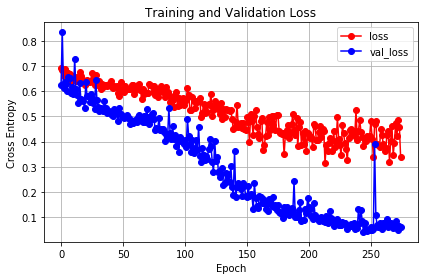

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label='loss')
plt.plot(val_loss, 'bo-', label='val_loss')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig('Training and Validation Loss.png')
plt.savefig('Training and Validation Loss.pdf')

In [14]:
plt.show()

## Saving the model (for the future)

In [12]:
model.save('model/inception_model.h5')